In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import linalg
import scipy.stats as sts 
from matplotlib.gridspec import GridSpec
import seaborn as sns
import warnings
import matplotlib.cbook
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import pickle
sys.path.append("../helpers/")

# !pip install json_tricks
# !pip install statsmodels

import json_tricks as jt

import scipy.stats as sts
from unit_selectivity import *

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore",category=UserWarning)
np.set_printoptions(suppress=True)



In [25]:

#a1 cells
with open('../Data/all_cells.json', 'r') as pf:
    ac = jt.load(pf)

with open('../Data/error_trials.json', 'r') as pf:
    ac2 = jt.load(pf)

#with open("pfc_units.pck","rb") as f:
#     ac = pickle.load(f)

# with open('utype.json', 'r') as pf:
#     pop_ids = np.array(jt.load(pf))

selectivity, pop_ids, _ = get_select_units(ac)

pop_ids = np.array(pop_ids)

pop_ids[pop_ids == 'none'] = 0
pop_ids[pop_ids == 'lc'] = 1
pop_ids[pop_ids == 'pc'] = 2

pop_ids = np.array(pop_ids,dtype="int")


In [26]:
print(len(ac))
print(len(ac2))

130
59


In [27]:
time= ac[0]["time"]
stims = np.unique(ac[0]["stim"])

# remove transition trials
stims_idx = np.array([s[-1] == "o" for s in stims])
stims = stims[~stims_idx]

In [28]:
def smooth(data,w=3):
    for i in range(len(data[0])-w):
        data[:,i] = np.mean(data[:,i:i+w],1)
    return data


sessions_ids = ["_".join(a["ulabel"].split("_")[:3]) for a in ac]


all_spike_counts = []
all_neuron_ids = []
all_population_ids = []
all_stims = []
all_sessions_ids = []
all_contexts = []
all_IA = []
all_IB = []
all_decisions = []

for neuron_id in range(len(ac)):
    neuron_data = ac[neuron_id]
    population_id = pop_ids[neuron_id]
    sessions_id = sessions_ids[neuron_id]

    all_spike_counts_neuron = []
    for stim in stims:
        decision = 0
        if (stim == "le_lo_lc") or (stim == "le_hi_lc"):
            decision = -1
        if (stim == "ri_lo_pc") or (stim == "le_lo_pc"):
            decision = 1
        
        spike_counts = neuron_data[stim]
        neuron_ids = [neuron_id]*len(spike_counts)
        population_ids = [population_id]*len(spike_counts)
        stims_neuron = [stim]*len(spike_counts)
        sessions_neuron = [sessions_id]*len(spike_counts)
        contexts = np.array([stim.split("_")[-1]]*len(spike_counts))
        decisions = np.array([decision]*len(spike_counts))
        contexts[contexts == 'none'] = 0
        contexts[contexts == 'lc'] = 1
        contexts[contexts == 'pc'] = 2
        IA,IB = np.array([[s.split("_")[0]=="ri",s.split("_")[1]=="lo"] for s in stims_neuron],dtype="int").T

        all_decisions.append(decisions)
        all_spike_counts_neuron.append(spike_counts)
        all_neuron_ids.append(neuron_ids)
        all_population_ids.append(population_ids)
        all_stims.append(stims_neuron)
        all_sessions_ids.append(sessions_neuron)
        all_contexts.append(contexts)
        all_IA.append(IA)
        all_IB.append(IB)

    counts = np.concatenate(all_spike_counts_neuron)
    #zscores all neuron's firing rate. Not how Remi does.
    #counts = (counts - np.mean(counts)) / np.std(counts)
    #all_spike_counts.append(smooth(counts,3))
    all_spike_counts.append(counts)

# convert to right dtype
all_decisions = np.concatenate(all_decisions).astype("int")
all_neuron_ids = np.concatenate(all_neuron_ids).astype("int")
all_sessions_ids = np.concatenate(all_sessions_ids).astype("str")
all_population_ids = np.concatenate(all_population_ids).astype("int")
all_stims = np.concatenate(all_stims).astype("str")
all_contexts = np.concatenate(all_contexts).astype("int")
all_spike_counts = np.concatenate(all_spike_counts).astype("int")
all_IA = np.concatenate(all_IA).astype("int")
all_IB = np.concatenate(all_IB).astype("int")



In [29]:

bins = ["bin_"+str(i) for i in range(len(time))]

df = pd.DataFrame()
df["neuron_id"] = all_neuron_ids
df["sessions_id"] = all_sessions_ids
df["population_id"] = all_population_ids
df["stims"] = all_stims
df["context"] = all_contexts
df["pre_stim"] = np.mean(all_spike_counts[:,time<0],1)
df["IA"] = all_IA
df["IB"] = all_IB
df["decision"] = all_decisions

for bi,b in enumerate(bins):
    df[b] = all_spike_counts[:,bi]


Text(0.5, 0, 'time to stimulus')

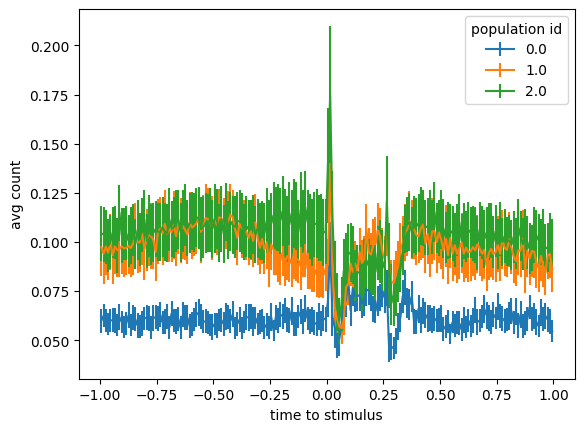

In [30]:
group = df.groupby(["neuron_id"]).mean().reset_index().groupby("population_id")
[plt.errorbar(time,group.mean().values[i,6:].T,group.sem().values[i,6:].T ,label=group.mean().index[i]) for i in range(3)]
plt.legend(title="population id")


plt.ylabel("avg count")
plt.xlabel("time to stimulus")
# plt.savefig("../figures/firing_rates_pop.png")

In [31]:
# run previous cell for error trials to generate df_err
# for i in np.unique(df.sessions_id):
#     pop = np.unique(df[df.sessions_id.values == i].population_id)[0]
#     if i in df_err.sessions_id.values:
#         idx = df_err.sessions_id == i
#         df_err.loc[idx,"population_id"] = pop

# np.unique(df_err.population_id.values)

(-0.25, 0.25)

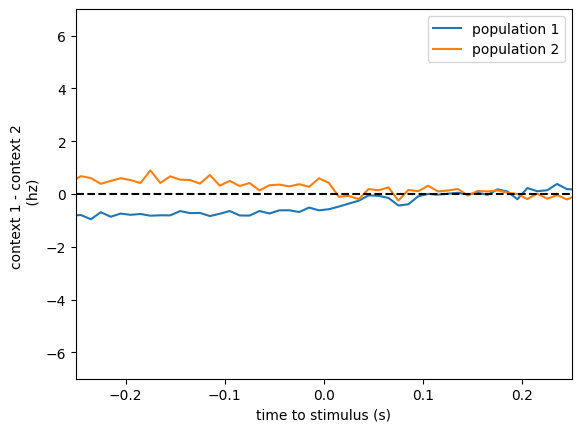

In [32]:
group = df[df.population_id != 0].groupby(["neuron_id","context"]).mean().reset_index().groupby(["context","population_id"]).mean()

# plt.subplot(2,1,1)
# [plt.plot(time,group.values[i,5:].T/0.05,label=group.index[i]) for i in range(4)]
# #plt.plot(time,df.mean().values[6:]/0.05)
# plt.legend(title="all neurons")
# plt.ylabel("hz")

# plt.subplot(2,1,2)
plt.plot(time,group.values[0,5:].T/0.05 - group.values[2,5:].T/0.05,label="population 1")
plt.plot(time,group.values[1,5:].T/0.05 - group.values[3,5:].T/0.05,label="population 2")
plt.plot(time,np.zeros_like(time),"k--")
plt.legend()

plt.xlabel("time to stimulus (s)")
plt.ylabel("context 1 - context 2 \n (hz)")
plt.ylim(-7,7)

#plt.savefig("../figures/firing_rate.png")
plt.xlim(-0.25,0.25)

Text(0.5, 0, 'time to stimulus (s)')

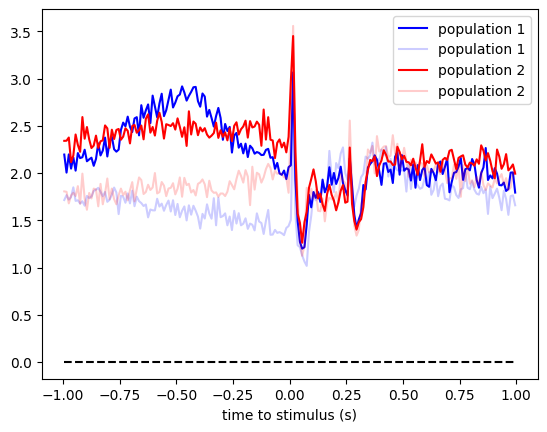

In [33]:
group = df[df.population_id != 0].groupby(["neuron_id","context"]).mean().reset_index().groupby(["context","population_id"]).mean()

# plt.subplot(2,1,1)
# [plt.plot(time,group.values[i,5:].T/0.05,label=group.index[i]) for i in range(4)]
# #plt.plot(time,df.mean().values[6:]/0.05)
# plt.legend(title="all neurons")
# plt.ylabel("hz")

# plt.subplot(2,1,2)
plt.plot(time,group.values[2,5:].T/0.05,label="population 1",color='blue')

plt.plot(time,group.values[0,5:].T/0.05,label="population 1",color='blue',alpha=0.2)

plt.plot(time,group.values[1,5:].T/0.05,label="population 2",color='red')
plt.plot(time,group.values[3,5:].T/0.05,label="population 2",color='red',alpha=0.2)
plt.plot(time,np.zeros_like(time),"k--")
plt.legend()

plt.xlabel("time to stimulus (s)")




Text(0.5, 0, 'context')

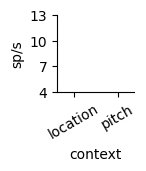

In [34]:
plt.figure(figsize=(1,1))

loc_loc = np.mean(group.values[2,5:25].T/0.05)
loc_pitch = np.mean(group.values[0,5:25].T/0.05)


pitch_pitch = np.mean(group.values[1,5:25].T/0.05)
pitch_loc = np.mean(group.values[3,5:25].T/0.05)


loc_loc_s = sts.sem(group.values[2,5:25].T/0.05)
loc_pitch_s = sts.sem(group.values[0,5:25].T/0.05)

pitch_pitch_s = sts.sem(group.values[1,5:25].T/0.05)
pitch_loc_s = sts.sem(group.values[3,5:25].T/0.05)

plt.bar([0,1,3,4],[loc_loc,pitch_loc,loc_pitch,pitch_pitch])
plt.errorbar([0,1,3,4],[loc_loc,pitch_loc,loc_pitch,pitch_pitch],[loc_loc_s,pitch_loc_s,loc_pitch_s,pitch_pitch_s],color='black')
plt.xticks([0.5,3.5],['location','pitch'],rotation=30)
plt.ylim(5,13)
plt.yticks([4,7,10,13])
sns.despine()
plt.ylabel('sp/s')
plt.xlabel('context')
#plt.savefig("../figures/firing_rate_absolute.svg")


In [35]:
np.shape(group.values[2,5:25].T/0.05)

(20,)

In [36]:

group_cx1 = df[df.context == 1].groupby("neuron_id")
group_cx2 = list(df[df.context == 2].groupby("neuron_id"))

p = []
dif = []
dif_stim1 = []
dif_stim2 = []
pop = []
for i,(k1,data1) in enumerate(group_cx1):
    k2,data2=group_cx2[i]
    #p.append(sts.ttest_ind(data1.pre_stim,data2.pre_stim)[1])
    p.append(mannwhitneyu(data1.pre_stim,data2.pre_stim, alternative="two-sided")[1])
    dif.append(data1.pre_stim.mean() - data2.pre_stim.mean())
    dif_stim1.append(np.mean(data1.values[:,-40:][20:25]) - data1.pre_stim.mean())
    dif_stim2.append(np.mean(data2.values[:,-40:][20:25]) - data2.pre_stim.mean())

    pop.append(data1.population_id.unique())

pop = np.concatenate(pop)
dif = np.array(dif)
dif_stim1 = np.array(dif_stim1)
dif_stim2 = np.array(dif_stim2)

In [37]:
print(sts.ttest_ind(dif_stim1[pop==2],dif_stim1[pop==1]))
print(sts.ttest_ind(dif_stim2[pop==2],dif_stim2[pop==1]))

Ttest_indResult(statistic=-2.752626186283618, pvalue=0.007312594991575449)
Ttest_indResult(statistic=1.7334522690440393, pvalue=0.08686796997992376)


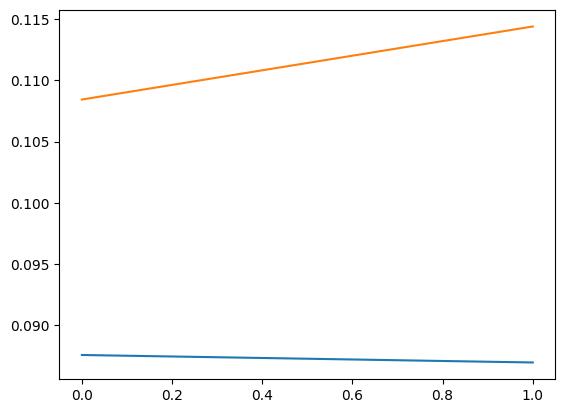

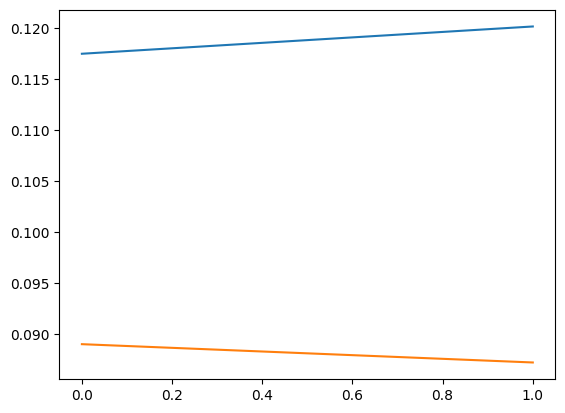

In [38]:

plt.figure()
plt.plot([0,1],[np.mean(group.values[0,5:][:20]),np.mean(group.values[0,5:][20:25])])
plt.plot([0,1],[np.mean(group.values[2,5:][:20]),np.mean(group.values[2,5:][20:25])])

plt.figure()

plt.plot([0,1],[np.mean(group.values[1,5:][:20]),np.mean(group.values[1,5:][20:25])])
plt.plot([0,1],[np.mean(group.values[3,5:][:20]),np.mean(group.values[3,5:][20:25])])



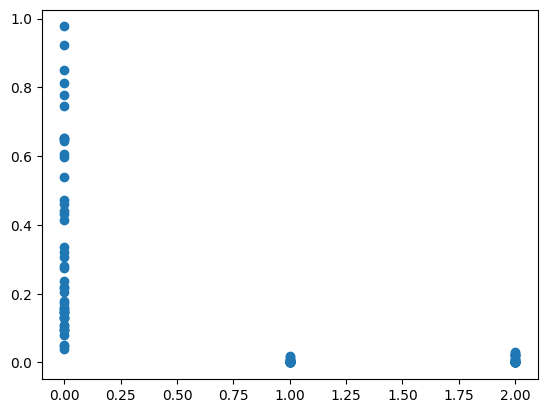

In [39]:
plt.plot(pop,p,"o")


In [40]:
from statsmodels.stats.multitest import multipletests
selectivity, c_pvals, *_ = multipletests(np.array(p), method='fdr_bh')

In [41]:
np.mean(selectivity)

0.6307692307692307

Text(0, 0.5, 'pre stim fr dif')

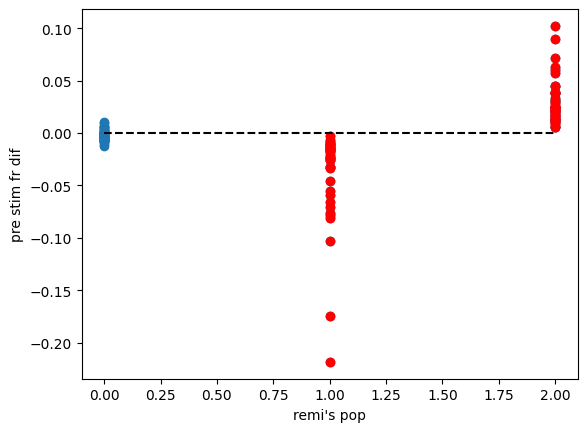

In [42]:
plt.plot(pop,dif,"o")
plt.plot(pop[selectivity],dif[selectivity],"ro")
plt.plot([0,2],[0,0],"k--")
plt.xlabel("remi's pop")
plt.ylabel("pre stim fr dif")

In [43]:
new_pops = []
for i,(neuron_id, data) in enumerate(df.groupby("neuron_id")):
    new_pop = 1 if dif[i]<0 else 2
    if not selectivity[i]: new_pop = 0
    _new_pops = new_pop * np.ones(len(data))
    new_pops+=list(_new_pops)

# check difference to Remi's clasification 
print(np.mean(abs(df["population_id"].values - np.array(new_pops))))

df["population_id"] = np.array(new_pops)


0.0


In [44]:
# df.to_csv(../Data/"RW_dataframe_A1_nozscore_25ms.csv",index=False)
#np.savetxt("../Data/time.txt",time)

In [45]:
df_z = pd.read_csv("../Data/RW_dataframe_A1_nozscore_smooth.csv")


In [46]:
df.groupby("neuron_id").mean().values[:,-40:]

array([[0.00888889, 0.00592593, 0.00888889, ..., 0.01185185, 0.01777778,
        0.0162963 ],
       [0.04033215, 0.05575326, 0.03321471, ..., 0.05219454, 0.02728351,
        0.03084223],
       [0.07704655, 0.06581059, 0.08346709, ..., 0.08186196, 0.08025682,
        0.0882825 ],
       ...,
       [0.1563786 , 0.13580247, 0.11111111, ..., 0.11522634, 0.11934156,
        0.13168724],
       [0.05349794, 0.11111111, 0.04526749, ..., 0.09053498, 0.06995885,
        0.08230453],
       [0.03703704, 0.0617284 , 0.06584362, ..., 0.06995885, 0.06995885,
        0.05349794]])

In [47]:
df_z.groupby("neuron_id").mean().values[:,-40:]

array([[0.1043956 , 0.09340659, 0.09340659, ..., 0.12087912, 0.15934066,
        0.15934066],
       [0.1043956 , 0.14835165, 0.15934066, ..., 0.07692308, 0.14835165,
        0.14835165],
       [1.79057592, 1.7382199 , 1.7486911 , ..., 1.45026178, 1.4973822 ,
        1.42408377],
       ...,
       [0.26805778, 0.26324238, 0.27126806, ..., 0.18619583, 0.25521669,
        0.23434992],
       [0.32263242, 0.27929374, 0.31460674, ..., 0.26645265, 0.23274478,
        0.2905297 ],
       [1.95987159, 2.0176565 , 2.07865169, ..., 1.78330658, 1.58266453,
        1.43499197]])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=af3700bb-635f-4f56-95cc-6d24931ab29c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>